In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pandas as pd

# Load the dataset
df = pd.read_csv('Phishing Websites Engineered.csv')

# Features and target
X = df.drop(columns='target')
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
rfc_model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rfc_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [3]:
y_pred3 = rfc_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Accuracy: 0.947008547008547
              precision    recall  f1-score   support

          -1       0.95      0.95      0.95       620
           1       0.94      0.95      0.94       550

    accuracy                           0.95      1170
   macro avg       0.95      0.95      0.95      1170
weighted avg       0.95      0.95      0.95      1170



🔍 SHAP Summary Plot - Random Forest


<ipython-input-4-d73aa4f9f309>:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(rfc_shap_values, sample)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

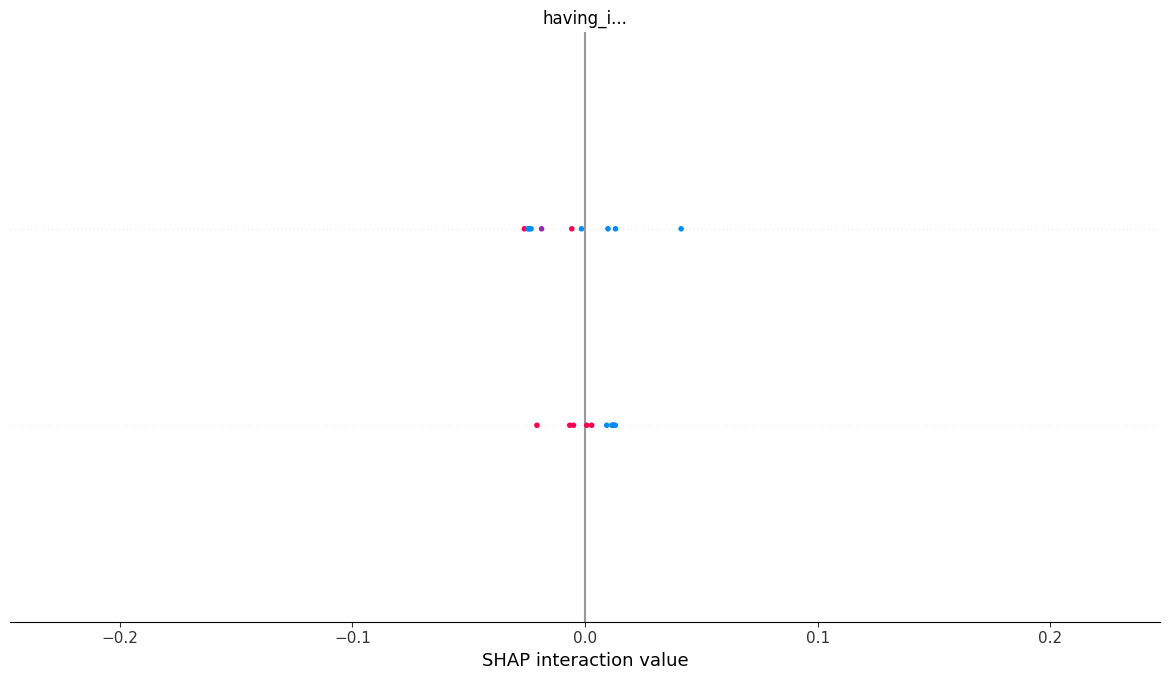

In [4]:
import shap
background = shap.sample(X_train, 100, random_state=42)

# Create SHAP explainers for each model
rfc_explainer = shap.Explainer(rfc_model.predict_proba, background)

# Pick a few test instances
sample = X_test.sample(10, random_state=42)

# Compute SHAP values
rfc_shap_values = rfc_explainer(sample)

# Visualize summary plots
print("🔍 SHAP Summary Plot - Random Forest")
shap.summary_plot(rfc_shap_values, sample)


In [5]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c1ce57dcb7b2e9db6a504794372668862419dcefed0b693897d3e9df7af92bdb
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [6]:
import lime
import lime.lime_tabular
import numpy as np


In [7]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['Legitimate', 'Phishing'],
    mode='classification'
)

In [8]:
def explain_instance_lime(model, model_name):
    i = np.random.randint(0, X_test.shape[0])
    exp = lime_explainer.explain_instance(
        X_test.iloc[i],
        model.predict_proba,
        num_features=10
    )
    print(f"\n🔍 LIME Explanation for model: {model_name} on instance {i}")
    exp.show_in_notebook(show_table=True)
    return exp

In [9]:
# Explain one instance with each model
explain_instance_lime(rfc_model, "Random Forest")


🔍 LIME Explanation for model: Random Forest on instance 354


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

# PDP & ICE

Partial Dependence Plots (PDP) for top 3 features


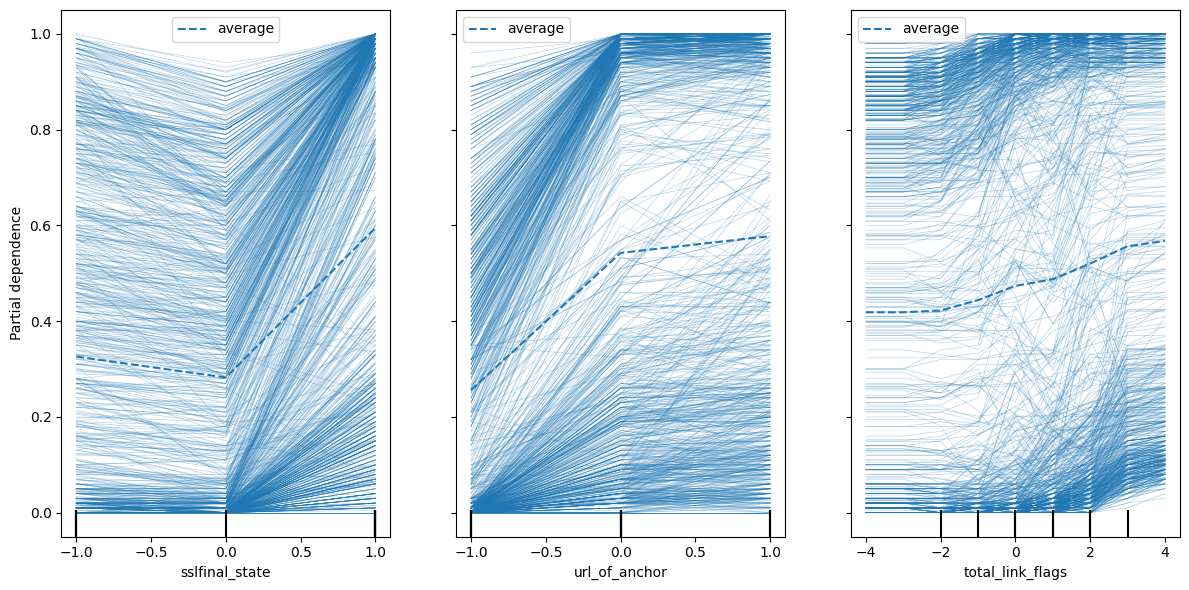

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

top_features = X.columns[rfc_model.feature_importances_.argsort()[::-1][:3]]

print("Partial Dependence Plots (PDP) for top 3 features")
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(rfc_model, X_train, features=top_features,kind="both", ax=ax)
plt.tight_layout()
plt.show()


# LOFO

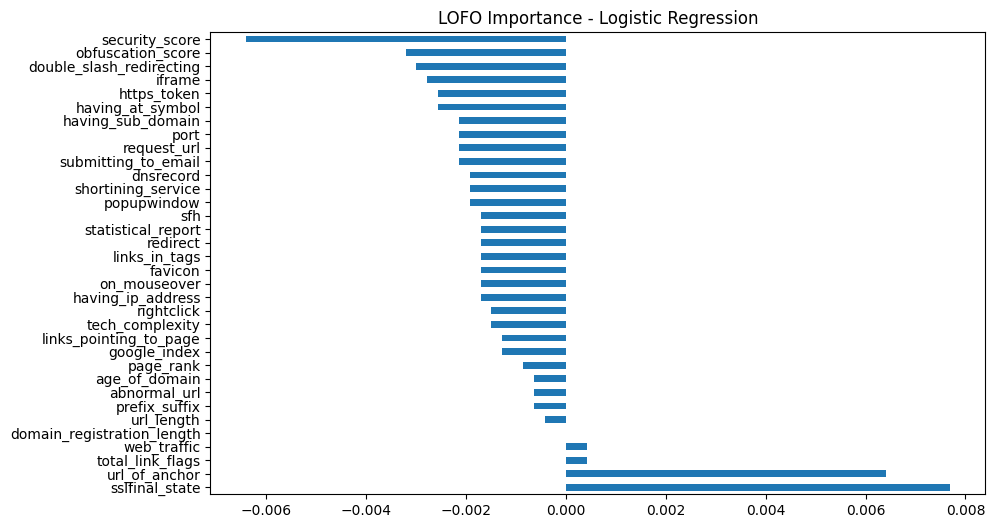

In [ ]:
from sklearn.model_selection import cross_val_score
baseline = cross_val_score(rfc_model, X_train, y_train, cv=5, scoring='accuracy').mean()

lofo_scores = {}
for col in X_train.columns:
    X_lofo = X_train.drop(columns=[col])
    score = cross_val_score(rfc_model, X_lofo, y_train, cv=5, scoring='accuracy').mean()
    lofo_scores[col] = baseline - score

# Create DataFrame for LOFO scores and plot
lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - Logistic Regression")
plt.show()

In [ ]:
print("\nTop 5 Features by LOFO Importance:")
print(lofo_df.head())


Top 5 Features by LOFO Importance:
sslfinal_state                0.007695
url_of_anchor                 0.006412
total_link_flags              0.000428
web_traffic                   0.000427
domain_registration_length   -0.000001
dtype: float64
